<a href="https://colab.research.google.com/github/tomo-nakayama/PDF_TIFF_CSV/blob/main/%E9%85%8D%E7%AE%A1%E7%B3%BB%E7%B5%B1%E5%9B%B3PDF20250305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pdf2image


In [3]:
!apt-get install poppler-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (333 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [4]:
!brew install poppler

/bin/bash: line 1: brew: command not found


回転角度: -0.32 度


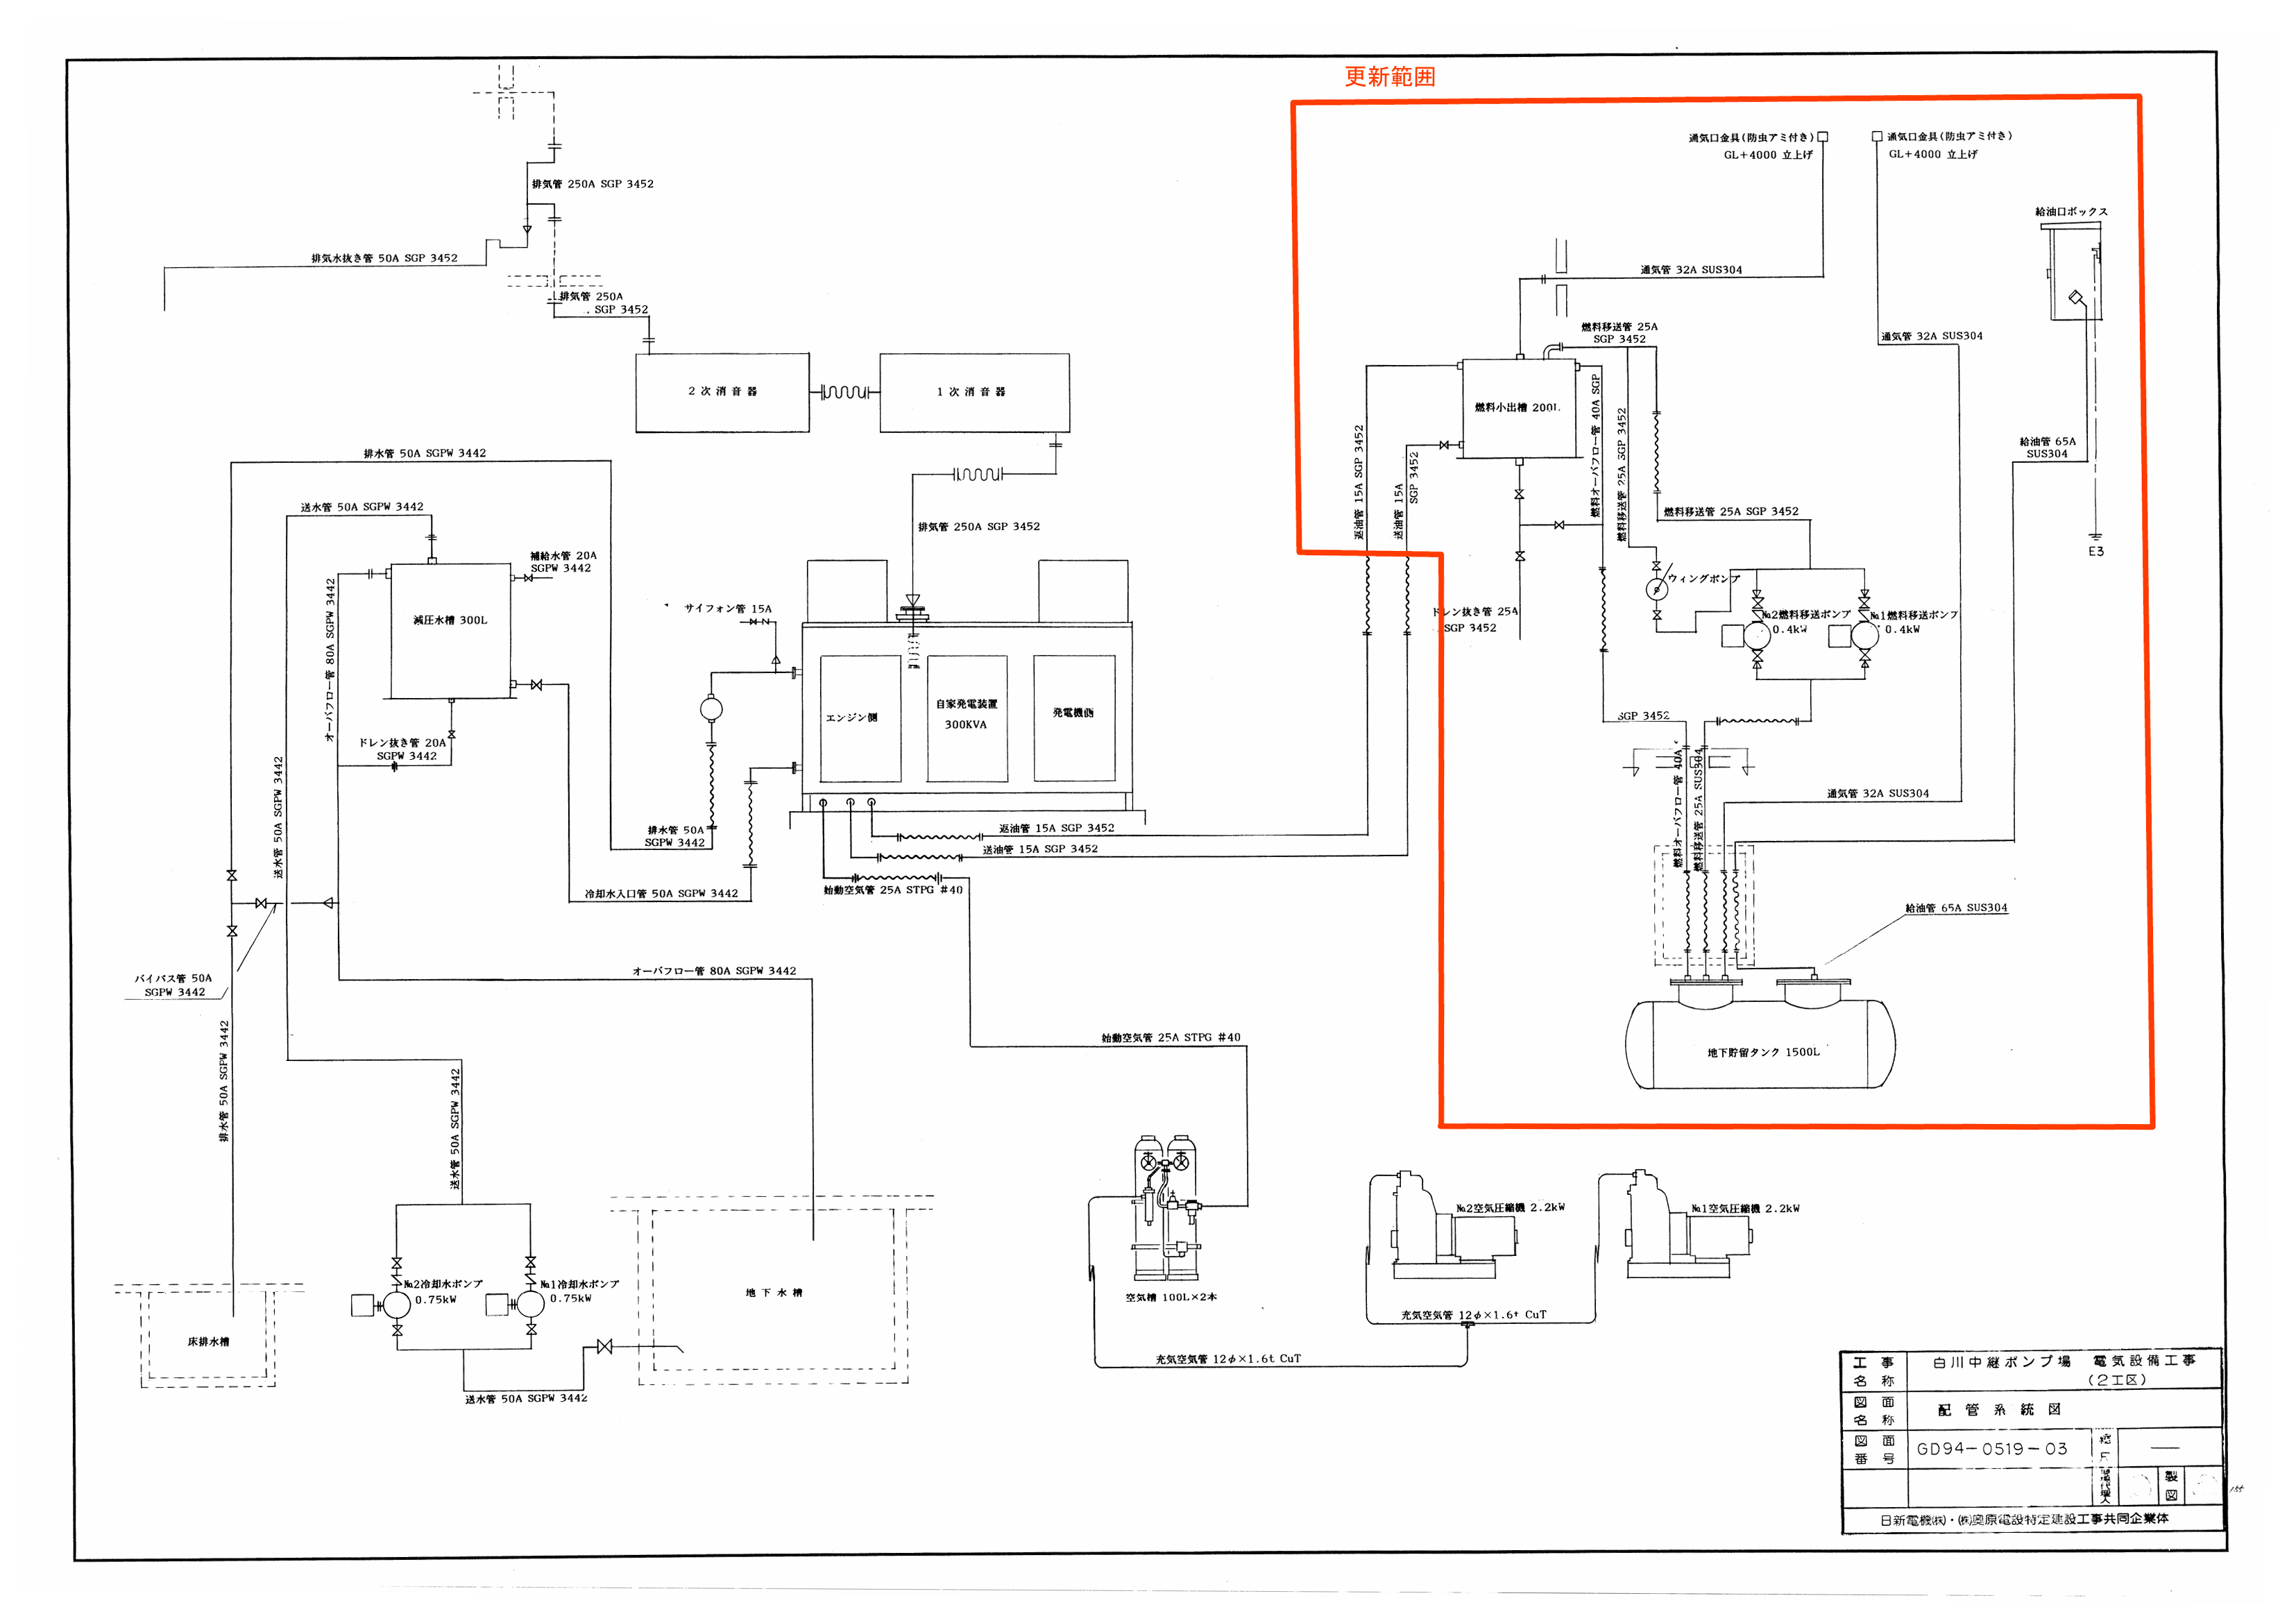

True

In [8]:
import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from google.colab.patches import cv2_imshow  # Colab での画像表示用

# PDFファイルを画像に変換
pdf_path = '/content/配管系統図.pdf'

# poppler_path を指定 (Windows の場合)
# poppler_path = r"C:\path\to\poppler\bin"  # 例: "C:\Program Files\Poppler\poppler-23.05.0\Library\bin"

try:
    # images = convert_from_path(pdf_path, poppler_path=poppler_path) # Windows の場合 poppler_path=poppler_path を指定
    images = convert_from_path(pdf_path) # Linux, macOS の場合
except Exception as e:
    print(f"PDF conversion failed: {e}")
    exit()

img = np.array(images[0]) # 最初のページをNumPy配列に変換

# OpenCVの画像形式に変換 (PIL Image -> NumPy Array -> BGR)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# グレースケール変換
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ノイズ除去 (メディアンフィルタ)
gray = cv2.medianBlur(gray, 5)

# 二値化 (適応的閾値処理)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 傾き補正 (ハフ変換による直線検出)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

angle = 0
if lines is not None:
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        angles.append(angle)
    angle = np.mean(angles)

# 回転
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# 回転角度を表示
print(f"回転角度: {angle:.2f} 度")

# 画像の表示 (google.colab.patches.cv2_imshow)
cv2_imshow(rotated)

# 結果の保存 (必要に応じて)
cv2.imwrite('processed_image.png', rotated)

In [ ]:
from pdf2image import convert_from_path

# PDFファイルのパス
pdf_path = "/content/No.2発電機施工図test.pdf"

# PDFから画像に変換（300dpi）
images = convert_from_path(pdf_path, dpi=300)

# 1ページ目の保存
image_path = "/content/No.2発電機施工図test_page1.tiff"
images[0].save(image_path, "TIFF")

print(f"TIFF画像を保存しました: {image_path}")


TIFF画像を保存しました: /content/No.2発電機施工図test_page1.tiff


In [ ]:
from PIL import Image
import numpy as np

# TIFF画像をPillowで開く
image_path = "/content/No.2発電機施工図test_page1.tiff"
try:
    img_pil = Image.open(image_path)
    print("PillowでTIFF画像を開きました。モード:", img_pil.mode)

    # OpenCVで扱えるNumPy配列に変換
    img = np.array(img_pil)

    # RGB画像ならグレースケールに変換
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    print("画像の変換に成功しました。")

except Exception as e:
    print(f"エラー: {e}")


PillowでTIFF画像を開きました。モード: RGB
エラー: name 'cv2' is not defined


In [14]:
# 1. OpenCVを使ってTIFF画像を読み込む
import cv2
import numpy as np

# TIFF画像の読み込み（カラー）
img = cv2.imread("/content/processed_image.tiff", cv2.IMREAD_COLOR)

# 2. カラー画像をグレースケール（輝度情報）に変換する
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 3. 照度レベルを3段階（暗・中・明）に分類する
dark = gray < 85  # 輝度が85未満のピクセルを「暗」と定義
medium = (gray >= 85) & (gray < 170)  # 輝度が85以上170未満を「中」と定義
bright = gray >= 170  # 輝度が170以上のピクセルを「明」と定義

# 4. 各照度レベルのピクセル数を出力する
print("Dark pixels:", np.sum(dark))  # 暗い領域のピクセル数を出力
print("Medium pixels:", np.sum(medium))  # 中間の領域のピクセル数を出力
print("Bright pixels:", np.sum(bright))  # 明るい領域のピクセル数を出力


Dark pixels: 145997
Medium pixels: 118685
Bright pixels: 7475069


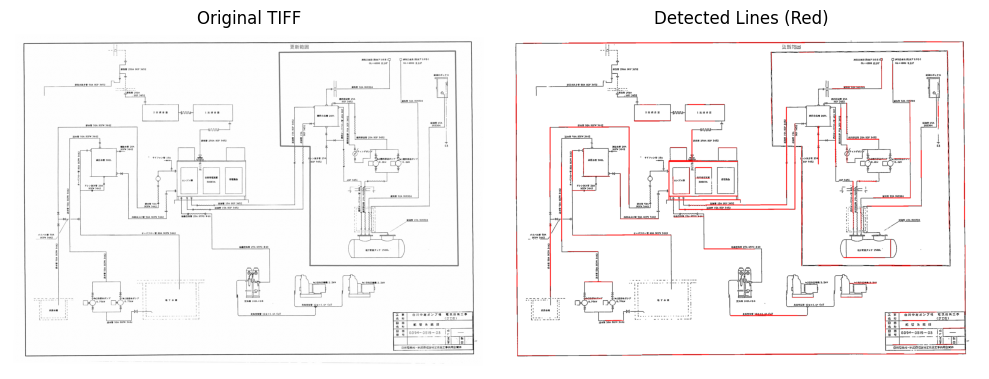

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1️⃣ TIFF画像を読み込み & 照度を上げる ---
tiff_path = "/content/processed_image.tiff"

# TIFF画像の読み込み（グレースケール）
img = cv2.imread(tiff_path, cv2.IMREAD_GRAYSCALE)

# 画像が読み込まれているか確認
if img is None:
    raise FileNotFoundError(f"Error: 画像が読み込めませんでした。パスを確認してください → {tiff_path}")

# 照度を上げるために明るさを増加
#enhanced_img = cv2.convertScaleAbs(img, alpha=1.8, beta=40)  # 明るさ調整 (alpha: コントラスト, beta: 明るさ)

# --- 2️⃣ ノイズ除去（GaussianBlur + Adaptive Threshold）---
#blurred = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
#binary_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# --- 3️⃣ Cannyエッジ検出 ---
edges = cv2.Canny(binary_img, 50, 150)

# --- 4️⃣ Hough変換で直線を検出 & 赤で描画 ---
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=200, minLineLength=100, maxLineGap=10)

# 画像をカラーに変換（赤い直線を描画するため）
color_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 赤い直線を描画

# --- 5️⃣ 不要なプロットを削除し、レイアウトを詰める ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 2つのプロットだけに変更

# 元画像
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original TIFF")
axes[0].axis("off")

# 直線検出結果
axes[1].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Detected Lines (Red)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


✅ 画像のサイズ: 3309 x 2339
✅ AutoCAD 用座標データを CSV に保存しました: /content/processed_image.csv


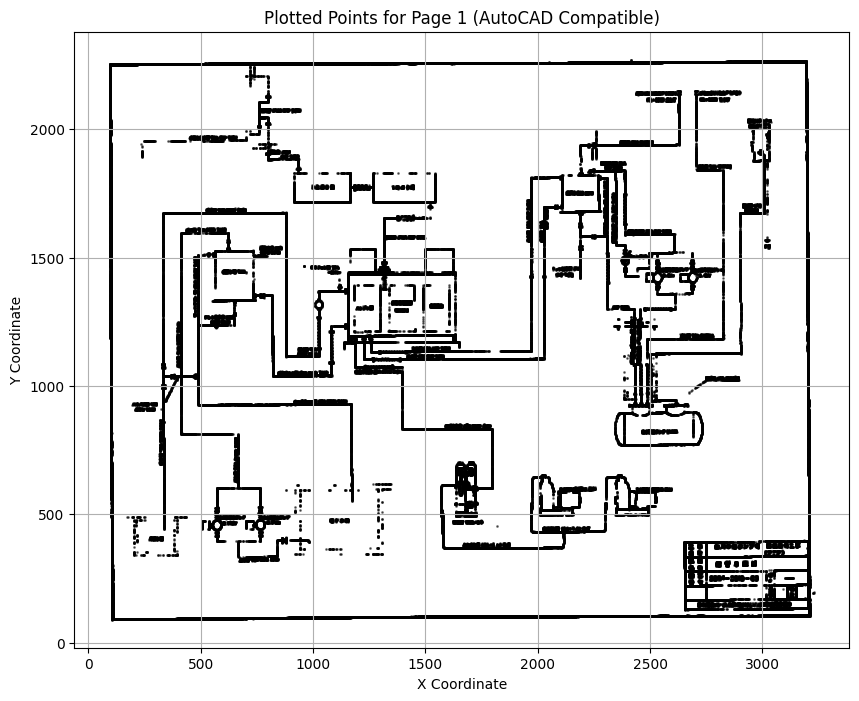

✅ TIFF から AutoCAD 用の CSV への変換とプロットが完了しました。


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- TIFFから座標データをCSVに保存 & 可視化 ---
for i in range(len(images)):
    tiff_file_path = f"/content/processed_image.tiff"
    img = Image.open(tiff_file_path).convert("L")

    # 画像のサイズを取得
    img_width, img_height = img.size
    print(f"✅ 画像のサイズ: {img_width} x {img_height}")

    # 画像を numpy 配列に変換
    img_array = np.array(img)

    # 黒いピクセルを抽出（しきい値を調整可能）
    threshold = 50  # 0（完全な黒）～255（白）
    black_pixels = np.column_stack(np.where(img_array < threshold))

    # 座標データを DataFrame に変換（AutoCAD用にY軸を反転）
    df_pixels = pd.DataFrame(black_pixels, columns=["Y", "X"])
    df_pixels["Y"] = img_height - df_pixels["Y"]  # Y軸の値を反転（AutoCAD用）

    # CSVとして保存
    csv_output_path = f"/content/processed_image.csv"
    df_pixels.to_csv(csv_output_path, index=False, header=["X", "Y"])

    print(f"✅ AutoCAD 用座標データを CSV に保存しました: {csv_output_path}")

    # --- プロット（座標データの可視化）---
    plt.figure(figsize=(10, 8))
    plt.scatter(df_pixels["X"], df_pixels["Y"], s=1, color="black", alpha=0.5)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Plotted Points for Page {i+1} (AutoCAD Compatible)")
    plt.grid(True)
    plt.show()

print("✅ TIFF から AutoCAD 用の CSV への変換とプロットが完了しました。")

✅ AutoCAD 用 `PLINE` コマンドを TXT に保存しました: /content/配管系統図_autocad_pline.txt


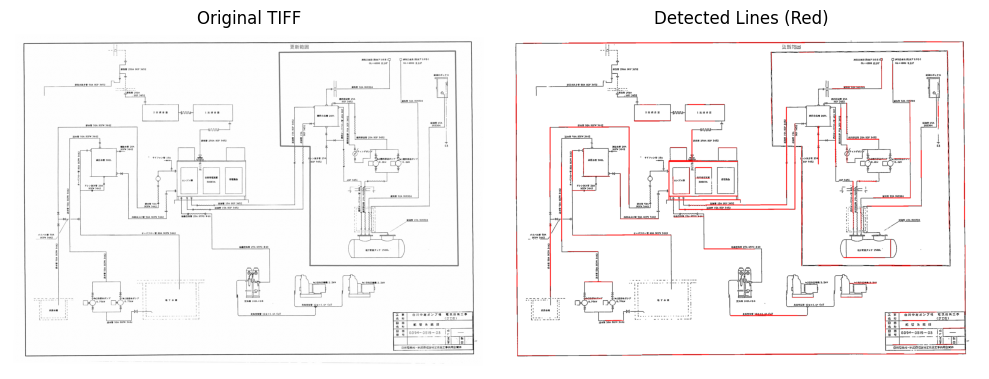

In [19]:
import cv2　　#ボツNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ TIFF画像を読み込み & 照度を上げる ---
tiff_path = "/content/processed_image.tiff"

# TIFF画像の読み込み（グレースケール）
img = cv2.imread(tiff_path, cv2.IMREAD_GRAYSCALE)

# 画像が読み込まれているか確認
if img is None:
    raise FileNotFoundError(f"Error: 画像が読み込めませんでした。パスを確認してください → {tiff_path}")

# 照度を上げるために明るさを増加
enhanced_img = cv2.convertScaleAbs(img, alpha=1.8, beta=40)

# --- 2️⃣ ノイズ除去（GaussianBlur + Adaptive Threshold）---
blurred = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
binary_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# --- 3️⃣ Cannyエッジ検出 ---
edges = cv2.Canny(binary_img, 50, 150)

# --- 4️⃣ Hough変換で直線を検出 & 赤で描画 ---
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=200, minLineLength=100, maxLineGap=10)

# 画像をカラーに変換（赤い直線を描画するため）
color_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)

# 赤線の座標を保存するリスト
red_lines_data = []

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 赤い直線を描画
        red_lines_data.append([x1, y1, x2, y2])  # 座標を保存

# --- 5️⃣ 近い点を統合して直線データを最適化 ---
df_red_lines = pd.DataFrame(red_lines_data, columns=["X1", "Y1", "X2", "Y2"])

# 近い点同士を統合する処理（線分の間隔を最適化）
tolerance = 5  # 直線の最適化間隔（ピクセル単位）
df_red_lines = df_red_lines.sort_values(by=["X1", "Y1"])  # 座標をソート

optimized_lines = []
prev_x1, prev_y1, prev_x2, prev_y2 = None, None, None, None

for _, row in df_red_lines.iterrows():
    x1, y1, x2, y2 = row["X1"], row["Y1"], row["X2"], row["Y2"]

    if prev_x1 is not None:
        # 直前の線との距離が近ければ結合
        if abs(prev_x2 - x1) < tolerance and abs(prev_y2 - y1) < tolerance:
            prev_x2, prev_y2 = x2, y2  # 線を延長
        else:
            optimized_lines.append([prev_x1, prev_y1, prev_x2, prev_y2])
            prev_x1, prev_y1, prev_x2, prev_y2 = x1, y1, x2, y2
    else:
        prev_x1, prev_y1, prev_x2, prev_y2 = x1, y1, x2, y2

# 最後の線分を追加
if prev_x1 is not None:
    optimized_lines.append([prev_x1, prev_y1, prev_x2, prev_y2])

# --- 6️⃣ AutoCAD の `PLINE` コマンド用に書き出し ---
# AutoCAD コマンドを `.txt` に保存
autocad_output_path = "/content/配管系統図_autocad_pline.txt"

with open(autocad_output_path, "w") as f:
    f.write("PLINE\n")  # PLINEコマンド開始
    for x1, y1, x2, y2 in optimized_lines:
        f.write(f"{x1},{y1}\n")  # 頂点座標
    f.write(f"{x2},{y2}\n") # 最後の頂点座標
    f.write("\n")
    f.write("\n") #改行
    f.write("CLOSE\n") # CLOSEコマンド
    f.write("\n") #改行

print(f"✅ AutoCAD 用 `PLINE` コマンドを TXT に保存しました: {autocad_output_path}")

# --- 7️⃣ 画像を表示 ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 元画像
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original TIFF")
axes[0].axis("off")

# 直線検出結果
axes[1].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Detected Lines (Red)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

✅ AutoCAD 用 `PLINE` コマンドをスクリプトファイルに保存しました: /content/配管系統図_autocad_pline.scr


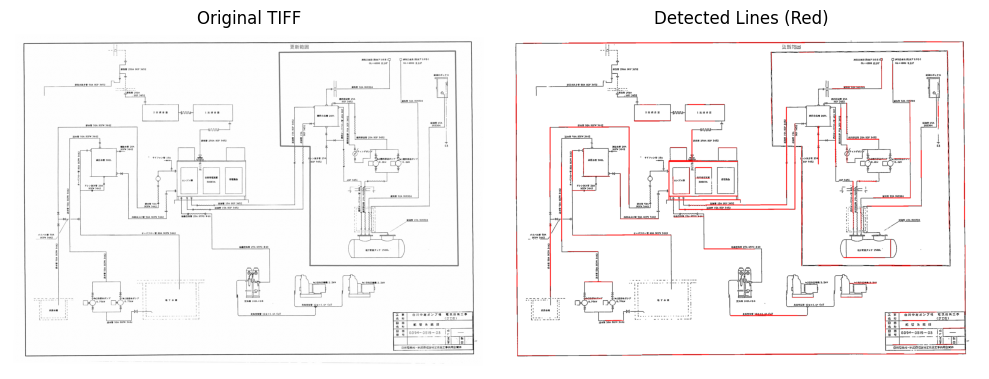

In [20]:
import cv2　#ボツNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ TIFF画像を読み込み & 照度を上げる ---
tiff_path = "/content/processed_image.tiff"

# TIFF画像の読み込み（グレースケール）
img = cv2.imread(tiff_path, cv2.IMREAD_GRAYSCALE)

# 画像が読み込まれているか確認
if img is None:
    raise FileNotFoundError(f"Error: 画像が読み込めませんでした。パスを確認してください → {tiff_path}")

# 照度を上げるために明るさを増加
enhanced_img = cv2.convertScaleAbs(img, alpha=1.8, beta=40)

# --- 2️⃣ ノイズ除去（GaussianBlur + Adaptive Threshold）---
blurred = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
binary_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# --- 3️⃣ Cannyエッジ検出 ---
edges = cv2.Canny(binary_img, 50, 150)

# --- 4️⃣ Hough変換で直線を検出 & 赤で描画 ---
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=200, minLineLength=100, maxLineGap=10)

# 画像をカラーに変換（赤い直線を描画するため）
color_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)

# 赤線の座標を保存するリスト
red_lines_data = []

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 赤い直線を描画
        red_lines_data.append([x1, y1, x2, y2])  # 座標を保存

# --- 5️⃣ 近い点を統合して直線データを最適化 ---
df_red_lines = pd.DataFrame(red_lines_data, columns=["X1", "Y1", "X2", "Y2"])

# 近い点同士を統合する処理（線分の間隔を最適化）
tolerance = 5  # 直線の最適化間隔（ピクセル単位）
df_red_lines = df_red_lines.sort_values(by=["X1", "Y1"])  # 座標をソート

optimized_lines = []
prev_x1, prev_y1, prev_x2, prev_y2 = None, None, None, None

for _, row in df_red_lines.iterrows():
    x1, y1, x2, y2 = row["X1"], row["Y1"], row["X2"], row["Y2"]

    if prev_x1 is not None:
        # 直前の線との距離が近ければ結合
        if abs(prev_x2 - x1) < tolerance and abs(prev_y2 - y1) < tolerance:
            prev_x2, prev_y2 = x2, y2  # 線を延長
        else:
            optimized_lines.append([prev_x1, prev_y1, prev_x2, prev_y2])
            prev_x1, prev_y1, prev_x2, prev_y2 = x1, y1, x2, y2
    else:
        prev_x1, prev_y1, prev_x2, prev_y2 = x1, y1, x2, y2

# 最後の線分を追加
if prev_x1 is not None:
    optimized_lines.append([prev_x1, prev_y1, prev_x2, prev_y2])

# --- 6️⃣ AutoCAD の `PLINE` コマンドをスクリプトファイル (.SCR) に書き出し ---
autocad_output_path = "/content/配管系統図_autocad_pline.scr"

with open(autocad_output_path, "w") as f:
    f.write("PLINE\n")  # PLINEコマンド開始
    for x1, y1, x2, y2 in optimized_lines:
        f.write(f"{x1},{y1}\n")  # 頂点座標
    f.write(f"{x2},{y2}\n") # 最後の頂点座標
    f.write("\n")
    f.write("\n") #改行
    f.write("CLOSE\n") # CLOSEコマンド
    f.write("\n") #改行

print(f"✅ AutoCAD 用 `PLINE` コマンドをスクリプトファイルに保存しました: {autocad_output_path}")

# --- 7️⃣ 画像を表示 ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 元画像
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original TIFF")
axes[0].axis("off")

# 直線検出結果
axes[1].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Detected Lines (Red)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

✅ AutoCAD 用 `LINE` コマンドをスクリプトファイルに保存しました: /content/配管系統図_autocad_lines.scr


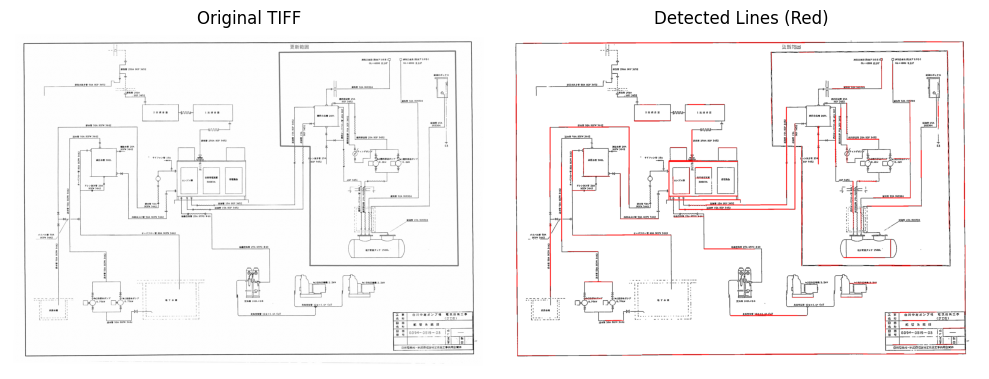

In [21]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ TIFF画像を読み込み & 照度を上げる ---
tiff_path = "/content/processed_image.tiff"

# TIFF画像の読み込み（グレースケール）
img = cv2.imread(tiff_path, cv2.IMREAD_GRAYSCALE)

# 画像が読み込まれているか確認
if img is None:
    raise FileNotFoundError(f"Error: 画像が読み込めませんでした。パスを確認してください → {tiff_path}")

# 照度を上げるために明るさを増加
enhanced_img = cv2.convertScaleAbs(img, alpha=1.8, beta=40)

# --- 2️⃣ ノイズ除去（GaussianBlur + Adaptive Threshold）---
blurred = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
binary_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# --- 3️⃣ Cannyエッジ検出 ---
edges = cv2.Canny(binary_img, 50, 150)

# --- 4️⃣ Hough変換で直線を検出 & 赤で描画 ---
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=200, minLineLength=100, maxLineGap=10)

# 画像をカラーに変換（赤い直線を描画するため）
color_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)

# 赤線の座標を保存するリスト
red_lines_data = []

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 赤い直線を描画
        red_lines_data.append([x1, y1, x2, y2])  # 座標を保存

# --- 5️⃣ 近い点を統合して直線データを最適化 ---
df_red_lines = pd.DataFrame(red_lines_data, columns=["X1", "Y1", "X2", "Y2"])

# 近い点同士を統合する処理（線分の間隔を最適化）
tolerance = 5  # 直線の最適化間隔（ピクセル単位）
df_red_lines = df_red_lines.sort_values(by=["X1", "Y1"])  # 座標をソート

optimized_lines = []
prev_x1, prev_y1, prev_x2, prev_y2 = None, None, None, None

for _, row in df_red_lines.iterrows():
    x1, y1, x2, y2 = row["X1"], row["Y1"], row["X2"], row["Y2"]

    if prev_x1 is not None:
        # 直前の線との距離が近ければ結合
        if abs(prev_x2 - x1) < tolerance and abs(prev_y2 - y1) < tolerance:
            prev_x2, prev_y2 = x2, y2  # 線を延長
        else:
            optimized_lines.append([prev_x1, prev_y1, prev_x2, prev_y2])
            prev_x1, prev_y1, prev_x2, prev_y2 = x1, y1, x2, y2
    else:
        prev_x1, prev_y1, prev_x2, prev_y2 = x1, y1, x2, y2

# 最後の線分を追加
if prev_x1 is not None:
    optimized_lines.append([prev_x1, prev_y1, prev_x2, prev_y2])

# --- 6️⃣ AutoCAD の `LINE` コマンドをスクリプトファイル (.SCR) に書き出し ---
autocad_output_path = "/content/配管系統図_autocad_lines.scr"

with open(autocad_output_path, "w") as f:
    # 各線分をLINEコマンドで記述
    for x1, y1, x2, y2 in optimized_lines:
        f.write("LINE\n")
        f.write(f"{x1},{y1}\n")
        f.write(f"{x2},{y2}\n")
        f.write("\n") # コマンド終了

print(f"✅ AutoCAD 用 `LINE` コマンドをスクリプトファイルに保存しました: {autocad_output_path}")

# --- 7️⃣ 画像を表示 ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 元画像
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original TIFF")
axes[0].axis("off")

# 直線検出結果
axes[1].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Detected Lines (Red)")
axes[1].axis("off")

plt.tight_layout()
plt.show()